<div style="text-align: right">  
Notebook by Hans de Moel en Marthe Wens <br>
STREAM water balance model by Jeroen Aerts et al.  <br>
Coding by Govert Alkemade and Joris Westenend </div>

Hydrology Practicum: STREAM model for the Colorado river
====================

# 1. Introduction
<div style="text-align: justify">  There are many different water models around. In this practical you will work with a raster-based hydrological model to simulate river discharge of the Colorado river in the USA. This model, called STREAM, is programmed in Matlab and Python and used in various studies performed at the Institute of Environmental Studies at the VU Amsterdam <a href="https://www.ivm.vu.nl/en/projects/Projects/spatial-analysis/stream/index.aspx">(Aerts et al., 1999)</a>. In this practical, STREAM will be run using a monthly time step, meaning that the model makes a calculation for each month to estimate river discharge and other variables.   Discharge will be simulated for the entire catchment up to the end of the river as shown in the figures (at the town of Yuma), which is where the Colorado river flows into Mexico.
</div>

# 2. STREAM MODEL CODE
## Setting up model specification 
<div style="text-align: justify"> These lines load the modules and the input settings for the model. <br> <br>
Open the excel file named ‘ClimateNumbering.xlsx’. In this excel file you will see a table indicating which iteration number corresponds with which month (column) and year (row). Take a look at this sheet and look up the iteration number that corresponds to January 1910 and December 1914. This 5-year period will be used to calibrate the model.</div>

In [1]:
# Setup Modules and settings
import os
os.chdir("G:/PhD/Projects/ASALI training/Practical_STREAM_Colorado_v2/Input")
import numpy as np
import pandas as pd
from osgeo import gdal
import matplotlib.pyplot as plt
np.seterr(invalid='ignore')
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Time and Space Parameters
dischargepointrow    = 228
dischargepointcolumn = 23
pixelsize = 5000
timestep  = 24*3600*30

## STREAM model input maps
<div style="text-align: justify">  These lines load the input files for the model. <br> <br> STREAM uses various types of maps as input. Some of these maps are dynamic, meaning that every time step a new map is imported. This is the case for temperature and precipitation, for which unique maps exist for every month starting from January 1901 up to December 2009.
Other input maps are static, meaning they are imported once at the beginning, and don’t change during the calculations. These include maps related to the slope in the catchment (for groundwater flow), the land cover in the catchment (for evapotranspiration calculation), and the water holding capacity of the soil.
Finally, there are some maps that are updated every time step. These are used for reservoirs for which the volume in the reservoir needs to be used in the next iteration. These include for instance snow, and water stored in the soil and groundwater reservoirs.  
 </div>

In [3]:
# Read land characteristic files
C      = np.loadtxt("cmap.asc", skiprows=6)
Cropf  = np.loadtxt("cropf.asc", skiprows=6)
Wholdn = np.loadtxt("wholdn.asc", skiprows=6) 
Wholdn[Wholdn==-9999]=75
Dem    = np.loadtxt("dem.asc", skiprows=6)

Mask = gdal.Open('basin.tif').ReadAsArray()
Mask[Mask==255]=0

Aw   = np.ones_like(Dem)
Gw   = np.ones_like(Dem)
Snow = np.ones_like(Dem)

In [4]:
# Read climatological data
Precipitation = np.load('pre.npy')
Temperature   = np.load('tmp.npy')
Heat          = np.load('Heat.npy')
A             = np.load('A.npy')

In [5]:
# Read observed data 
discharge = pd.read_csv('calibration.csv')
discharge.columns =['Year', 'Month', 'OBS'] 

## STREAM model function
<div style="text-align: justify"> These lines are the code for the the STREAM model in the form of a function (that can be called later on).  <br> <br>
STREAM is a distributed grid-based water-balance model and describes the hydrological cycle of a drainage basin as a series of storage compartments and flows. STREAM calculates per grid cell a water balance. The model consists of three storage reservoirs: snow storage, soil moisture storage and groundwater storage, dividing outflow into a fast and a slow component. The fast component is affected by soil moisture storage and the slow component by ground water storage, both behaving as linear reservoirs. Potential evapotranspiration is derived from surface temperature, following the approach of Thornthwaite and Mather (1957). Snow accumulation is equal to precipitation when temperature is below zero degrees Celsius, and snow melts linearly depending on temperature. Both fast and slow flows are routed to the basin outlet by flow accumulation using an elevation and assuming that all water moves through the system in one time step (in case of this practical: month). Because STREAM only needs precipitation and temperature as dynamic input variables, it is relatively simple and transparent to use  </div>

In [6]:
# Start iteration over all time steps
def stream_calc(timestart,timeend,timestep,Precipitation,Temperature,Heat,A,C, Cropf,Wholdn,DEM,Aw,Gw,Snow,dischargepointrow,dischargepointcolumn):
    
    
    # Create lists to store results in
    
    TimeseriesQsec   = []
    TimeseriesPre    = []
    TimeseriesGw     = []
    TimeseriesTmp    = []
    TimeseriesPe     = []
    TimeseriesExcess = []
    TimeseriesAw     = []
    TimeseriesRunoff = []

    
    # Start iteration over all time steps
    
    for i in range(timestart,timeend):   

        
        # Reading climate scenario data and converting to the right resolution
        
        Prei = Precipitation[i,:,:]
        Pre  = np.kron(Prei, np.ones((10,10)))
        Tmpi = Temperature[i,:,:]
        Tmp  = np.kron(Tmpi, np.ones((10,10)))
        
        
        # Calculate snow fall, snow cover storage and snow melt
        
        Snowfall = np.copy(Pre)
        Snowfall[Tmp>3] = 0 #At high temperatures no snow falls
        Snow     = Snow + Snowfall
        Melt     = (MELTcal * Tmp) #Snow will melt at high temperatures
        Melt[Tmp<3] = 0
        Melt2    = np.minimum(Snow,Melt)
        Snow     = Snow - Melt2
        Pre      = Pre - Snowfall + Melt2

        
        # Calculate potential evapotranspiration using Thornthwaite Equation and adjusting for crop coefficients
       
        Pe = np.full_like(Tmp,np.nan)
        Heat = Heat * HEATcal
        Pe[Tmp<26.5]  = 16*((10*(Tmp[Tmp<26.5]/Heat[Tmp<26.5]))**A[Tmp<26.5])
        Pe[Tmp>=26.5] = -415.85+(32.24*Tmp[Tmp>=26.5])-(0.43*(Tmp[Tmp>=26.5]**2)) # Different if it is very hot   
        Pe[Tmp<=0]    = 0 # Different if it is freezing cold 
        Pe = (Pe*Cropf/10*CROPFcal)

        
        # Calculate soil storage according to Thornthwaite-Mather
        
        ##compare available water with water holding capacity
        Peff   = Pre-Pe
        Aw_1   = np.copy(Aw)   
        Excess = np.zeros_like(Peff)
        Wholdn = Wholdn * WHOLDNcal 
        
        ##Soil is wetting below capacity
        below_cap = (np.add(Aw_1,Peff))<= Wholdn 
        Aw[below_cap] = Aw_1[below_cap] + Peff[below_cap]
        Excess[below_cap] = 0
        
        ##Soil is wetting above capacity
        above_cap = (np.add(Aw_1,Peff))> Wholdn    
        Excess[above_cap] = Aw_1[above_cap] + Peff[above_cap] - Wholdn[above_cap]
        Aw[above_cap] = Wholdn[above_cap]
        
        ##Soil is drying    
        Aw[Peff<=0] = Aw_1[Peff<=0]*np.exp(Peff[Peff<=0]/Wholdn[Peff<=0])
        Excess[Peff<=0] = 0

        #Separate direct from delayed runoff (seepage to groundwater)
        Runoff = TOGWcal*Excess
        Togw = Excess-Runoff

        #Calculate volume of groundwater and baseflow
        Gw = Gw+Togw
        Sloflo = (Gw/(C*Ccal))
        Gw = Gw-Sloflo

        
        # Calculate discharge accumulation (snow melt + runoff + baseflow),  
        # and create map of total monthly discharge per cel
        
        Dschrg = Runoff+Sloflo
        Dschrg = (Dschrg/1000)*pixelsize*pixelsize # conversion from mm to m^3

        
        # Accumulate discharge from above lying cels (in mm and in m3/sec)
       
        Qsec = np.sum(Dschrg[Mask==1])/timestep    

        
        # Save output from that time series
        
        TimeseriesQsec.append(Qsec)
        TimeseriesPre.append(np.mean(Pre))
        TimeseriesGw.append(np.mean(Gw)) 
        TimeseriesTmp.append(np.mean(Tmp)) 
        TimeseriesPe.append(np.mean(Pe))   
        TimeseriesExcess.append(np.mean(Excess)) 
        TimeseriesAw.append(np.mean(Aw)) 
        TimeseriesRunoff.append(np.mean(Runoff)) 

    
    # Save the output
    
    np.save('Aw.npy', Aw)
    np.save('Gw.npy', Gw)
    np.save('Snow.npy', Snow)
    np.savetxt('Qsec.txt',TimeseriesQsec)
    
    
    return TimeseriesQsec

# 3. Excercises for the Colorado river 

There are questions throughout this exercises which you have to answer by adjusting the code.  

## First exploration run 
First run the full model, but only for 5 years: 1910 to 1914. Do the calculated discharge values allign with the observed, blue graphs?

In [7]:
# Start and end time of iteration
# These are the iteration numbers of January 1910 (start) and December 1914 (end). 
timestart = ???      # Start day of simulation
timeend   = ???      # End day of simulation

# Make new discharge dataset
discharge_exploration = discharge.loc[(discharge['Year']>= ???) & (discharge['Year']<= ???)]

In [8]:
# Calibration parameters
HEATcal   = 1.0     # Not used in this practical: default=1 [>0]
WHOLDNcal = 1.0     # Water holding capacity of the soil: default=1 [>0]
MELTcal   = 10.0    # How fast snow melts: default=10 [>0]
CROPFcal  = 1.0     # Parameter steering the evapotranspiration: default=1 [>0]
TOGWcal   = 0.4     # Parameter seperating the fraction going to groundwater and direct runoff: default=0.4 [0-1]
Ccal      = 1.0     # Parameter steering how fast groundwater flows: default=1 [>1]

In [9]:
# Calculate the discharge over time using STREAM (here the function prepared above is activated) and add it to our main file
discharge_exploration['CAL'] = np.round(stream_calc(timestart,timeend,timestep,Precipitation,Temperature,Heat,A,C,Cropf,Wholdn,Dem,Aw,Gw,Snow,dischargepointrow,dischargepointcolumn))

In [ ]:
# Average per month observational data
OBSdischarge = np.zeros(12)
for i in range(12):
    OBSdischarge[i]= discharge_exploration.loc[discharge_exploration['Month']==(i+1)]['OBS'].mean()

# Average per month calculated data
CALdischarge = np.zeros(12)
for i in range(12):
    CALdischarge[i]= discharge_exploration.loc[discharge_exploration['Month']==(i+1)]['CAL'].mean()

In [10]:
# Compare calculated CAL with observed OBS totals (Hint: use np.sum(...) and the / sign and np.corrcoef(...)[1][1] )

Difference = ???
print('The ratio between calculated and observed monthly discharge is ',Difference,'%')

Correlation = ???
print('The correlation between calculated and observed average monthly discharge is ',Correlation,'%')

The ratio between calculated and observed discharge is  0.8176134609447361 %
The correlation between calculated and observed discharge is  0.9999999999999998 %


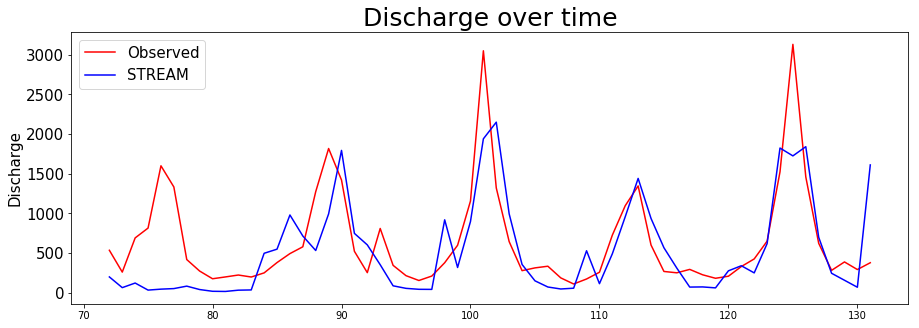

In [11]:
# Compare calculated with observed values over time

fig = plt.figure(figsize=(15, 5))

plt.plot(discharge_exploration['OBS'], 'r', label='Observed')
plt.plot(discharge_exploration['CAL'], 'b', label='STREAM')

plt.title('Discharge over time', fontsize=25)
plt.ylabel('Discharge', fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper left', fontsize=15)

plt.show()

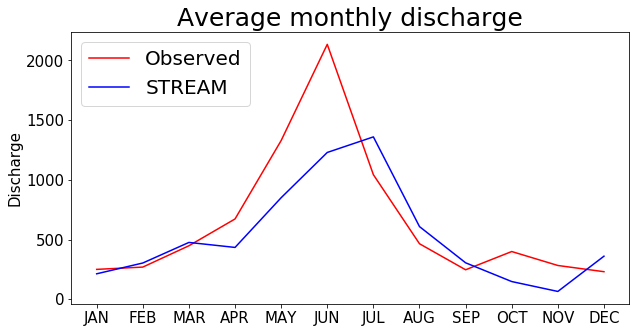

In [12]:
# Compare calculated with monlty average values 

fig = plt.figure(figsize=(10, 5))

plt.plot(OBSdischarge, 'r', label='Observed')
plt.plot(CALdischarge, 'b', label='STREAM')

plt.title('Average monthly discharge', fontsize=25)
plt.ylabel('Discharge', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(np.arange(12), ('JAN', 'FEB', 'MAR', 'APR', 'MAY','JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC'), fontsize=15)
plt.legend(loc='upper left', fontsize=20)


plt.show()

## Calibrating the model 
<div style="text-align: justify"> <br> 1. Change snow-melt <br>
After you’ve compared the graphs, you’ll have noticed whilst the general picture seems to be there, there are many differences. We’ll now try and fix this by calibrating the model using several parameters. One of the discrepancies you may have spotted is that the peak of the discharge modelled by STREAM seems to be a month too late compared to the observed discharge data. We’ll try and fix this by increasing the effect of snow-melt. In the script  you’ll see that the MELTcal parameter is set to 10. Double this number to 20 and run the model again. <br> <br>
2. Change evapotranspiration <br>
When you look at the average annual discharge you’ll see that the modelled discharge is lower than the observed discharge. This is also shown by the ‘Difference’ statistic above, which should state that the modelled discharge is ~112% of the observed discharge. We’ll try and adjust this by reducing the evapotranspiration. Change the value of CROPFcal to 0.85 (instead of 1). Run the script again.  <br> <br>
3. Change start year <br>
You’ll notice that the height of the peaks is now much better than before. However, there seems to be a large discrepancy in the first year. We’ll try to fix this by starting the simulation in January 1909 instead of 1910. Look up the iteration number of January 1909 in the excel file. Then use this number for ‘timestart’, meaning that the simulation will start at January 1909 instead of January 1910. Run the model again. There is now 6 years of data (72 months), but we’ll just take the results from 1910-1914; in other words, we’ll disregard the first 12 results. <br> <br>
3. Perfectionise <br>
If you want, you can change the calibration parameters a bit further. For instance, increase the TOGWcal a bit. Remember that you can continue calibrating until eternity, but some discrepancies will never improve. Keep an eye on Ratio (which should be around 1), and the Correlation coefficient (R) (which you want as close to 1 as possible). <br> <br>
4. Long run 
<div style="text-align: justify"> With the hydrological model calibrated, we can now do a long run and see how well it performs over a longer time. Look up the iteration numbers for January 1904 and December 1933 and run the model for this 30 year period.  Does the calibrated hydrological model perform well over the entire run? </div> </div> 

In [13]:
# Start and end time of iteration
timestart = ???      # Start day of simulation
timeend   = ???      # End day of simulation

# Make new discharge dataset
discharge_calibration = discharge.loc[(discharge['Year']>= ???) & (discharge['Year']<= ???)]


In [14]:
# Calibration parameters
HEATcal   = ???     # Not used in this practical: default=1 [>0]
WHOLDNcal = ???     # Water holding capacity of the soil: default=1 [>0]
MELTcal   = ???     # How fast snow melts: default=10 [>0]
CROPFcal  = ???     # Parameter steering the evapotranspiration: default=1 [>0]
TOGWcal   = ???     # Parameter seperating the fraction going to groundwater and direct runoff: default=0.4 [0-1]
Ccal      = ???     # Parameter steering how fast groundwater flows: default=1 [>1]

In [15]:
# Calculate the discharge over time using STREAM
discharge_calibration['CAL'] = stream_calc(timestart,timeend,timestep,Precipitation,Temperature,Heat,A,C, Cropf,Wholdn,Dem,Aw,Gw,Snow,dischargepointrow,dischargepointcolumn)[-60:]


In [ ]:
# Average per month observational data
OBSdischarge = np.zeros(12)
for i in range(12):
    OBSdischarge[i]= discharge_calibration.loc[discharge_calibration['Month']==(i+1)]['OBS'].mean()

# Average per month calculated data
CALdischarge = np.zeros(12)
for i in range(12):
    CALdischarge[i]= discharge_calibration.loc[discharge_calibration['Month']==(i+1)]['CAL'].mean()

In [16]:
# Compare calculated CAL with observed OBS totals

Difference = np.sum(discharge_calibration['CAL'])/np.sum(discharge_calibration['OBS'])
print('The ratio between calculated and observed discharge is ',Difference,'%')

Correlation = np.corrcoef(CALdischarge, OBSdischarge)[1][1]
print('The correlation between calculated and observed discharge is ',Correlation)

The ratio between calculated and observed discharge is  0.8573502446754446 %
The correlation between calculated and observed discharge is  0.9999999999999998


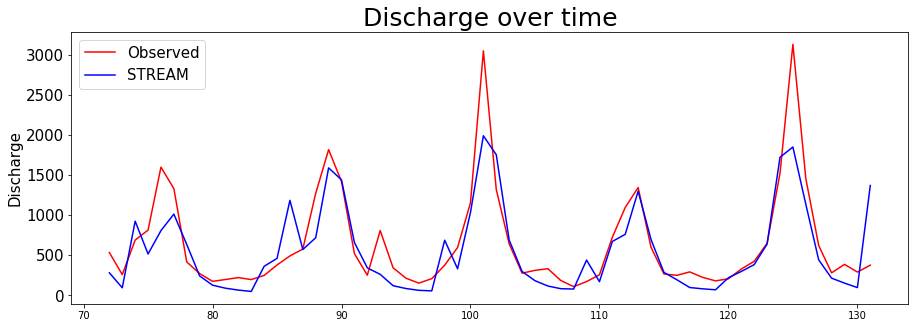

In [17]:
# Compare calculated with observed values over time

fig = plt.figure(figsize=(15, 5))

plt.plot(discharge_calibration['OBS'], 'r', label='Observed')
plt.plot(discharge_calibration['CAL'], 'b', label='STREAM')

plt.title('Discharge over time', fontsize=25)
plt.ylabel('Discharge', fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper left', fontsize=15)

plt.show()

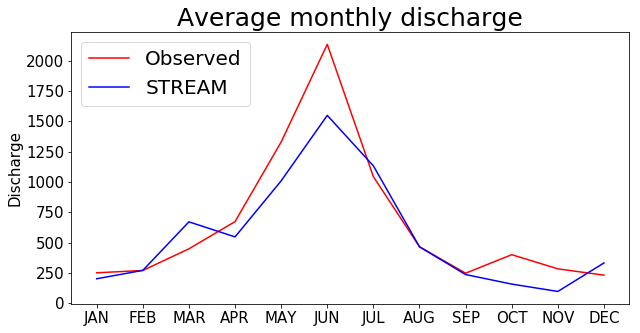

In [18]:
# Compare calculated with monlty average values 

fig = plt.figure(figsize=(10, 5))

plt.plot(OBSdischarge, 'r', label='Observed')
plt.plot(CALdischarge, 'b', label='STREAM')

plt.title('Average monthly discharge', fontsize=25)
plt.ylabel('Discharge', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(np.arange(12), ('JAN', 'FEB', 'MAR', 'APR', 'MAY','JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC'), fontsize=15)
plt.legend(loc='upper left', fontsize=20)


plt.show()
plt.show()

## Effect of Climate Change
<div style="text-align: justify"> <br> Now we will do some experiments with the calibrated model to see how climate change may affect discharge. we can use the calibrated model to see how climate change might possibly affect the availability of water resources in the Colorado catchment. Often this is done by loading in new precipitation and temperature maps generated by climate models. Here, however, we will take a simpler approach and just adjust temperature and precipitation manually, making this more a sensitivity analysis. <br><br>

1. Effects of Precipitation<br>
We’ll start with precipitation. Search in the script where the precipitation (PRE) and temperature (TMP) map are respectively imported. Add a new line in between where you add 10% precipitation. Then run the model again and check the results. <br> <br>

2. Effects of temperature rise<br>
Now we’ll do temperature. Disable the line you just created for precipitation by putting a ‘#’ sign in front of it (you’ll see it will turn green). Then create a new line after the importing of the TMP map, where you increase the temperature with 2 degrees. Run the model again and check the results. <br> <br>

2. Combined effect<br>
Finally, we can take a look at the combined effect of increased precipitation and temperature. Enable the line where you increased the precipitation  and run the model again. Discuss the results.
</div>

In [30]:
# Start and end time of iteration
timestart =  ???      # Start day of simulation
timeend   =  ???      # End day of simulation
   
# Make new discharge dataset with correct years
discharge_climatechange = discharge.loc[(discharge['Year']>= ???) & (discharge['Year']<= ???)]


In [33]:
# Calculate the discharge over time using STREAM without climate change effects
Precipitation = np.load('pre.npy')
Temperature   = np.load('tmp.npy')
discharge_climatechange['CAL'] = stream_calc(timestart,timeend,timestep,Precipitation,Temperature,Heat,A,C,Cropf,Wholdn,Dem,Aw,Gw,Snow,dischargepointrow,dischargepointcolumn)

# Calculate the discharge over time using STREAM without climate change effects
Precipitation = ???
Temperature   = ???
discharge_climatechange['CAL_CC'] = stream_calc(timestart,timeend,timestep,Precipitation,Temperature,Heat,A,C,Cropf,Wholdn,Dem,Aw,Gw,Snow,dischargepointrow,dischargepointcolumn)

In [ ]:
# Average per month observational data
OBSdischarge = np.zeros(12)
for i in range(12):
    OBSdischarge[i]= discharge_climatechange.loc[discharge_climatechange['Month']==(i+1)]['OBS'].mean()

# Average per month calculated data
CALdischarge = np.zeros(12)
for i in range(12):
    CALdischarge[i]= discharge_climatechange.loc[discharge_climatechange['Month']==(i+1)]['CAL'].mean()
       
# Average per month calculated data with CC
CALCCdischarge = np.zeros(12)
for i in range(12):
    CALCCdischarge[i]= discharge_climatechange.loc[discharge_climatechange['Month']==(i+1)]['CAL_CC'].mean()

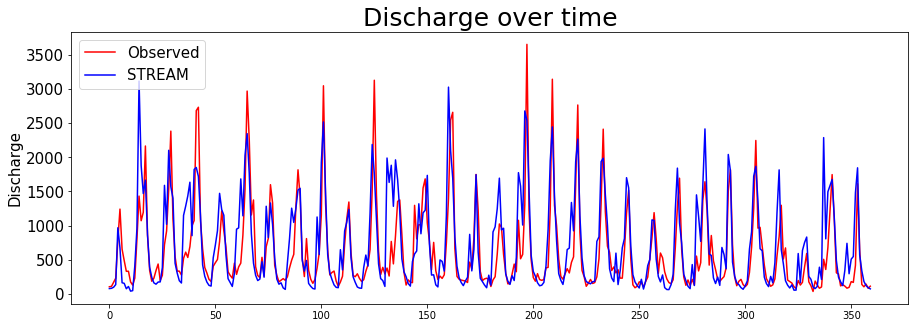

In [35]:
# Compare calculated with observed values over time
fig = plt.figure(figsize=(15, 5))

plt.plot(discharge_climatechange['OBS'], 'r', label='Observed')
plt.plot(discharge_climatechange['CAL'], 'b', label='STREAM')
plt.plot(discharge_climatechange['CAL'], 'k', label='STREAM_CC')

plt.title('Discharge over time', fontsize=25)
plt.ylabel('Discharge', fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper left', fontsize=15)

plt.show()

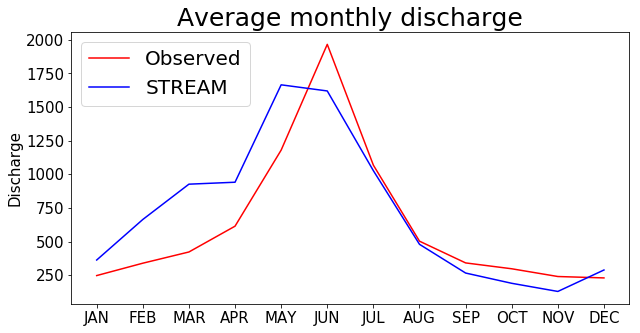

In [36]:
# Compare calculated with monlty average values 

fig = plt.figure(figsize=(10, 5))

plt.plot(OBSdischarge, 'r', label='Observed')
plt.plot(CALdischarge, 'b', label='STREAM')
plt.plot(CALCCdischarge, 'k', label='STREAM_CC')

plt.title('Average monthly discharge', fontsize=25)
plt.ylabel('Discharge', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(np.arange(12), ('JAN', 'FEB', 'MAR', 'APR', 'MAY','JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC'), fontsize=15)
plt.legend(loc='upper left', fontsize=20)

plt.show()
plt.show()

In [ ]:
# Calculate the change in average annual discharge (hint: use np.sum() and / )
annualdischarge_NO = np.sum(CALdischarge)
annualdischarge_CC = np.sum(CALCCdischarge)
dischargechange = ( annualdischarge_NO - annualdischarge_CC ) / annualdischarge_NO
print('The change in discharge due to climate change in the Colorado river is ',np.round(dischargechange),' %')

## Effect of water use
<div style="text-align: justify"> <br> Now you’ve set up a hydrological model for the Colorado river basin in the USA, we’ll look at recent changes in the discharge of the Colorado river basin. <br> 
We can have a look at the Colorado river discharge for the period 1904-1994. Look up the iteration numbers, adjust them accordingly in the script and run the model. Use the calibrated values. You’ll notice that the averages don’t correspond at all. Identify the reason for the big discrepancy in the averages: Look up from when it starts ‘going wrong’, what could have happened in reality?<br>
The U.S. bureau of reclamation monitors water in the Colorado basin closely and frequently publishes all kinds of reports, including ones on the use and loss of water. Go to the following website: http://www.usbr.gov/uc/library/envdocs/reports/crs/crsul.html and download the report on consumptive uses and losses for the years 1991-1995 (which roughly corresponds with our period). There are a lot of numbers in the report, estimate the average water use and loss per year by calculating an average of the 5 years that are reported.
<br> <br> 
1.	Estimate water use <br>
Clearly, a lot of water is consumed in the Colorado river basin. The difference in the modelled discharge and the observed discharge can be seen as a proxy of how much water is extracted and used in the basin.  We can estimate this from our model (see script below the graph) by recalculating the difference in discharge per month into a volume. We are going to do this for the last 6 years in our set (1989-1994). The easiest thing to do is to first translate the m3/sec into m3/month. Do this by multiplying the m3/sec with the amount of seconds that is in a month (assumed 30 days a month). Then we can recalculate the m3 into acre-feet, as that is the unit used in the USA for such numbers. One acre-foot corresponds to 1233.48 m3.  </div>

In [ ]:
# Start and end time of iteration
timestart =  ???  # Start day of simulation
timeend   =  ???  # End day of simulation

# Make new discharge dataset with correct years
discharge_long = discharge.loc[(discharge['Year']>= ??? ) & (discharge['Year']<= ??? )]   

In [ ]:
# Calculate the discharge over time using STREAM
discharge_long['CAL'] = stream_calc(timestart,timeend,timestep,Precipitation,Temperature,Heat,A,C, Cropf,Wholdn,Dem,Aw,Gw,Snow,dischargepointrow,dischargepointcolumn)

In [ ]:
# Compare calculated with observed values over time
fig = plt.figure(figsize=(15, 5))

plt.plot(discharge_long['OBS'], 'r', label='Observed')
plt.plot(discharge_long['CAL'], 'b', label='STREAM')

plt.title('Discharge over time', fontsize=25)
plt.ylabel('Discharge', fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper left', fontsize=15)

plt.show()

In [ ]:
# Calculate the average monthly water use as described above
discharge_wateruse = discharge_long.loc[(discharge['Year']>=1989) & (discharge['Year']<=1994)]   

# Calculate difference in CAL and OBS discharge
discharge_wateruse['wateruse']    = ??? 
# convert to per month
discharge_wateruse.loc['wateruse']= ???   
#  convert to acre-feet
discharge_wateruse.loc['wateruse']= ???? 

montlhywateruse = np.zeros(12)
for i in range(12):
    montlhywateruse[i]= discharge_wateruse.loc[discharge_wateruse['Month']==(i+1)]['wateruse'].mean()

# Calculate the total annual water use (hint: use np.sum())
totalannualwateruse = 
print('The average annual water use from the Colorado river is ',np.round(totalannualwateruse),' acre-feet')

 

In [ ]:
# Visualise effects

fig = plt.figure(figsize=(10, 5))

y_pos = np.arange(len(montlhywateruse))
plt.bar(y_pos, montlhywateruse, align='center', alpha=0.5)
plt.title('Average monthly water use', fontsize=25)
plt.ylabel('acre-feet water', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(y_pos, ('JAN', 'FEB', 'MAR', 'APR', 'MAY','JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC'), fontsize=15)

plt.show()  